This notebook demonstrates Kausal framework on Reaction-Diffusion (in 2D spatial dimension) dynamics. 

> __NOTE__: If you have not already done so, run through the notebook on `coupled_rossler` to get a sense of the overall workflow.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

import numpy as np
import torch
import torchdiffeq

import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc

from kausal.generator import reaction_diffusion_2d
from kausal.koopman import Kausal
from kausal import stats
from kausal.baselines import conditional_tigramite, conditional_varlingam
from kausal.baselines import magnitude_tigramite, magnitude_varlingam, magnitude_tsci, magnitude_clstm, magnitude_gvar
from kausal.baselines import plot_anomalies, get_anomalies, normalize
from kausal.observables import RandomFourierFeatures, TimeDelayFeatures, CNNFeatures

import warnings
warnings.filterwarnings('ignore')

/burg/glab/users/jn2808/.conda/envs/kausal/lib/python3.10/site-packages/jaxtyping/__init__.py:244: UserWarning: jaxtyping version >=0.2.23 should be used with Equinox version >=0.11.1
  warnings.warn(
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


# 1. Generate dynamics 
This time we use explicit coupling between reaction-diffusion equation.

$$
\frac{\partial u}{\partial t} = D_u \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right) - u (u - a)(u - 1) + \beta v,
$$

$$
\frac{\partial v}{\partial t} = D_v \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right) - v (v - b)(v - 1) + \gamma u.
$$

With coupling terms, and the following conditions for causal direction: if $\beta = 0$, $u \rightarrow v$ ; else if $\gamma = 0$, $v \rightarrow u$.

__Here, we use $\gamma = 0$, with the causal direction $v \rightarrow u$.__

In [3]:
# Spatial domain
Lx, Ly = 1.0, 1.0
Nx, Ny = 16, 16
dx, dy = Lx / (Nx - 1), Ly / (Ny - 1)
X, Y = torch.meshgrid(
    torch.linspace(0, Lx, Nx), 
    torch.linspace(0, Ly, Ny), 
    indexing="ij"
)

# Time span
t0, t1 = 0.0, 10.0
dt = 0.001 

# Parameters
D_u, D_v = 0.1, 0.1  # Diffusion coefficients
a, b = 0.3, 0.3  # Reaction parameters

# Stability constraint for time step
max_dt = min(dx**2 / (2 * D_u), dy**2 / (2 * D_u))
dt = min(dt, max_dt)
steps = int((t1 - t0) / dt)
n_train = int(0.8 * steps)

# Initial conditions
u_init = a + 0.1 * torch.exp(-50 * ((X - 0.5) ** 2 + (Y - 0.5) ** 2))  # Near a
v_init = b + 0.1 * torch.exp(-50 * ((X - 0.5) ** 2 + (Y - 0.5) ** 2))  # Near b
initial_state = torch.cat([u_init.ravel(), v_init.ravel()])

# Coupling coefficients
beta, gamma = 10.0, 0.0  # gamma = 0 (v --> u), beta = 0 (u --> v)
params = (D_u, D_v, a, b, beta, gamma, Nx, Ny, dx, dy)


In [4]:
# Integration
solver = torchdiffeq.odeint

def solve_dynamics(t0, t1, dt, initial_state, params):
    """Solve dynamics"""
    t = torch.linspace(t0, t1, int((t1 - t0) / dt))
    dynamics = lambda t, state: reaction_diffusion_2d(t, state, params)
    
    solution = solver(
        dynamics,
        initial_state,
        t,
        method='dopri5',
        options={'max_num_steps': 100000}
    )
    return t, solution

t, solution = solve_dynamics(t0, t1, dt, initial_state, params)

# Extract solutions for u and v
omega_1 = solution[:, :Nx * Ny].T.reshape((1, Nx, Ny, steps)) # U, True effect variables
omega_2 = solution[:, Nx * Ny:].T.reshape((1, Nx, Ny, steps)) # V, True cause variables


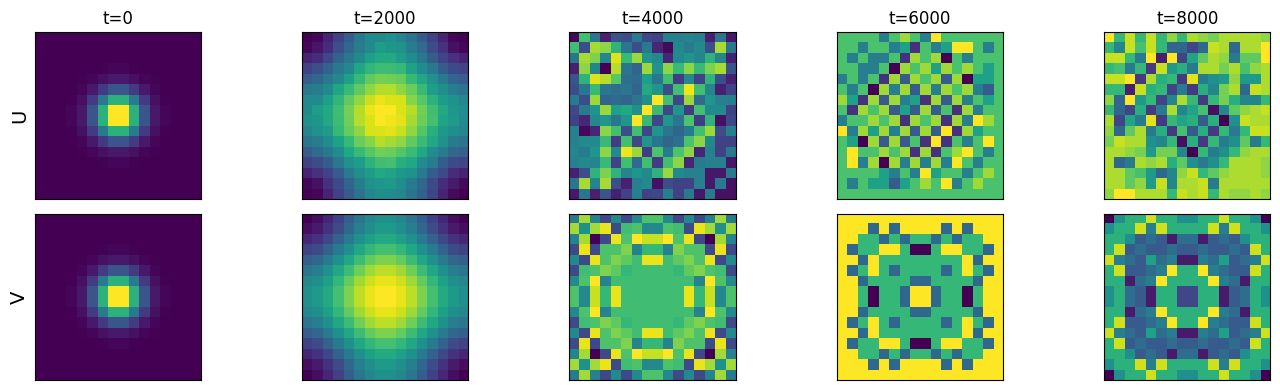

In [5]:
# Plot
n_plot = 5
n_skip_plot = steps // n_plot
f, ax = plt.subplots(2, n_plot, figsize=(14,4))

for i in range(n_plot):
    ax[0,i].imshow(omega_1[0, :, :, ::n_skip_plot][:, :, i])
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[0,i].set_title(f't={i*n_skip_plot}')
    
    ax[1,i].imshow(omega_2[0, :, :, ::n_skip_plot][:, :, i])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])

ax[0,0].set_ylabel('U', fontsize=14)
ax[1,0].set_ylabel('V', fontsize=14)
plt.tight_layout()
plt.show()
# f.savefig("docs/reaction_diffusion.png", dpi=200, bbox_inches="tight");


# 2. Causal Koopman

### 2a. Causal dependence with increasing shifts

In [6]:
# Initialize Kausal object, where we can pass in the cause-effect variables to be analyzed

## Test C --> E (true causal direction)
causal_koopman = Kausal(
    cause = omega_2,
    effect = omega_1,
)

## Test E --> C (false causal direction)
noncausal_koopman = Kausal(
    cause = omega_1,
    effect = omega_2
)


In [7]:
# Causal effect is estimated through the (marginal - joint) loss
time_shifts = torch.arange(1, 2000, 50)

## 1. Causal effect
causal_effect = causal_koopman.evaluate_multistep(time_shifts = time_shifts)

## 2. Non-causal effect
non_causal_effect = noncausal_koopman.evaluate_multistep(time_shifts = time_shifts)

## 3. Hypothesis testing the causal relationship
pval_cause = stats.hypothesis_testing(estimator=causal_koopman, time_shift=1000, n_permutes=30)
pval_non_cause = stats.hypothesis_testing(estimator=noncausal_koopman, time_shift=1000, n_permutes=30)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:58<00:00,  1.46s/it]


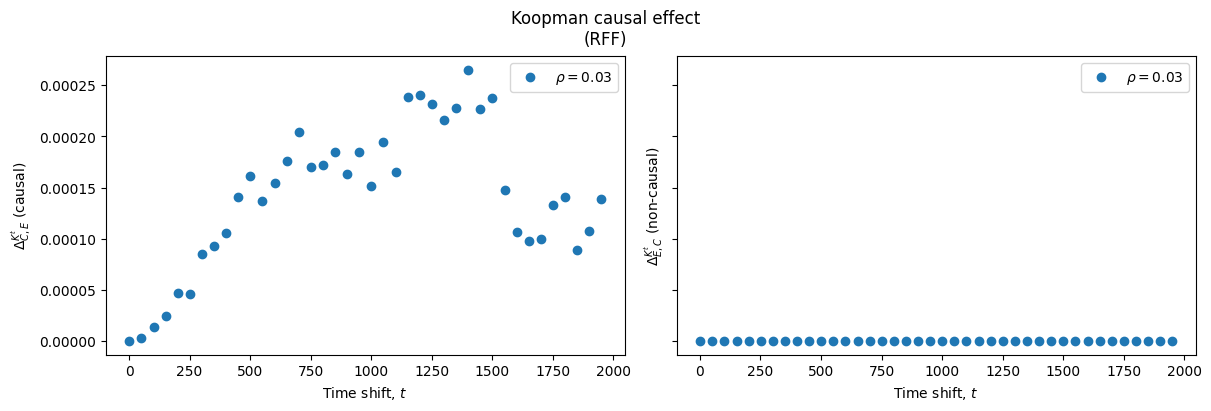

In [8]:
# Plot causal shift
# NOTE: increasing causal error in the true causal direction as time dependency increases.
# NOTE: also significant difference between C --> E and E --> C, indicating strong causal signal between C --> E

f, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True, constrained_layout=True)
ax[0].scatter(time_shifts, causal_effect, label=rf'$\rho = {pval_cause:.2f}$')
ax[0].set_xlabel(r'Time shift, $t$')
ax[0].set_ylabel(r'$\Delta^{K^t}_{C,E}$ (causal)')

ax[1].scatter(time_shifts, non_causal_effect, label=rf'$\rho = {pval_non_cause:.2f}$')
ax[1].set_xlabel(r'Time shift, $t$')
ax[1].set_ylabel(r'$\Delta^{K^t}_{E,C}$ (non-causal)')

ax[0].legend()
ax[1].legend()
f.suptitle(f'Koopman causal effect\n(RFF)')
plt.show();


# 3. Deep Causal Koopman

### 3a. Causal dependence with increasing shifts

Now, we use neural network (encoder-decoder __CNN__) to approximate the lifting operators, i.e., y(t) = f[x(t)], where x(t) is the high-dimensional non-linear states, and y(t) is the observables. We perform similar causal analysis as above!

In [9]:
# Initialize Kausal object, where we now specify DL-based observable functions.

# Specify hyperparameters
hidden_channels = [16, 32, 64, 128]

## Test C --> E (true causal direction)
causal_koopman = Kausal(
    marginal_observable = CNNFeatures(in_channels=1, hidden_channels=hidden_channels, out_channels=1),
    joint_observable = CNNFeatures(in_channels=2, hidden_channels=hidden_channels, out_channels=1),
    cause = omega_2,
    effect = omega_1,
)

## Test E --> C (false causal direction)
noncausal_koopman = Kausal(
    marginal_observable = CNNFeatures(in_channels=1, hidden_channels=hidden_channels, out_channels=1),
    joint_observable = CNNFeatures(in_channels=2, hidden_channels=hidden_channels, out_channels=1),
    cause = omega_1,
    effect = omega_2
)


In [10]:
# We first have to fit/train the observable functions
lr = 1e-4
epochs = 50
batch_size = 32

# 1. Causal direction
marginal_loss_ce, joint_loss_ce = causal_koopman.fit(
    n_train = n_train, 
    epochs = epochs, 
    lr = lr, 
    batch_size = batch_size
)

# 2. Non-causal direction
marginal_loss_ec, joint_loss_ec = noncausal_koopman.fit(
    n_train = n_train, 
    epochs = epochs, 
    lr = lr, 
    batch_size = batch_size
)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:22<00:00,  2.19it/s]


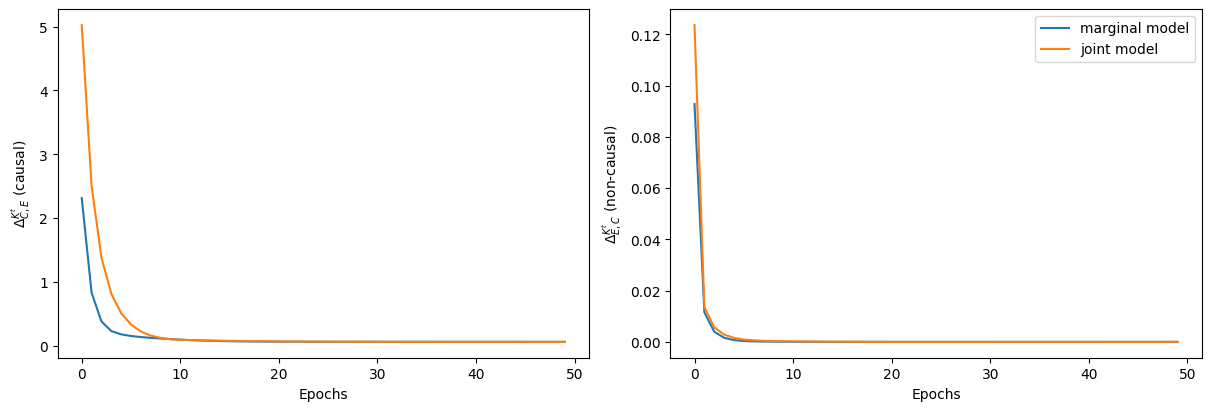

In [11]:
# Plot training losses
f, ax = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
ax[0].plot(marginal_loss_ce, label='marginal model')
ax[0].plot(joint_loss_ce, label='joint model')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel(r'$\Delta^{K^t}_{C,E}$ (causal)')

ax[1].plot(marginal_loss_ec, label='marginal model')
ax[1].plot(joint_loss_ec, label='joint model')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel(r'$\Delta^{K^t}_{E,C}$ (non-causal)')

plt.legend()
plt.show();


### 3a. Causal dependence with increasing shifts

In [12]:
# Causal effect is estimated through the (marginal - joint) loss
time_shifts = torch.arange(1, 2000, 50)

## 1. Causal effect
causal_effect = causal_koopman.evaluate_multistep(time_shifts = time_shifts)

## 2. Non-causal effect
non_causal_effect = noncausal_koopman.evaluate_multistep(time_shifts = time_shifts)

## 3. Hypothesis testing the causal relationship
pval_cause = stats.hypothesis_testing(estimator=causal_koopman, time_shift=1000, n_permutes=30)
pval_non_cause = stats.hypothesis_testing(estimator=noncausal_koopman, time_shift=1000, n_permutes=30)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:18<00:00,  2.18it/s]


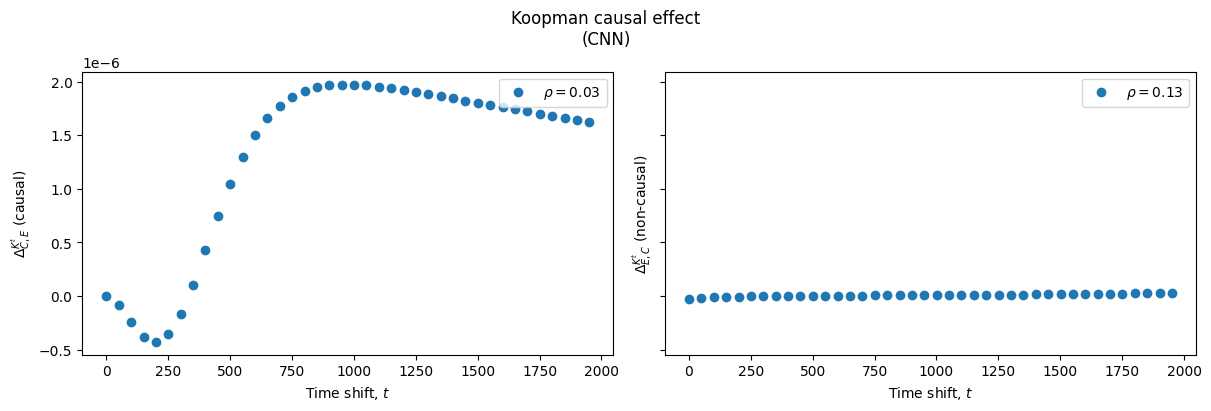

In [13]:
# Plot causal shift
# NOTE: increasing causal error in the true causal direction as time dependency increases.
# NOTE: also significant difference between C --> E and E --> C, indicating strong causal signal between C --> E

f, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True, constrained_layout=True)
ax[0].scatter(time_shifts, causal_effect, label=rf'$\rho = {pval_cause:.2f}$')
ax[0].set_xlabel(r'Time shift, $t$')
ax[0].set_ylabel(r'$\Delta^{K^t}_{C,E}$ (causal)')

ax[1].scatter(time_shifts, non_causal_effect, label=rf'$\rho = {pval_non_cause:.2f}$')
ax[1].set_xlabel(r'Time shift, $t$')
ax[1].set_ylabel(r'$\Delta^{K^t}_{E,C}$ (non-causal)')

ax[0].legend()
ax[1].legend()
f.suptitle(f'Koopman causal effect\n(CNN)')
plt.show();


# 4. Ablation

Here we perform additional experiments, including performing an ensemble of causal measures to quantify representation uncertainty.

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:18<00:00,  2.19it/s]


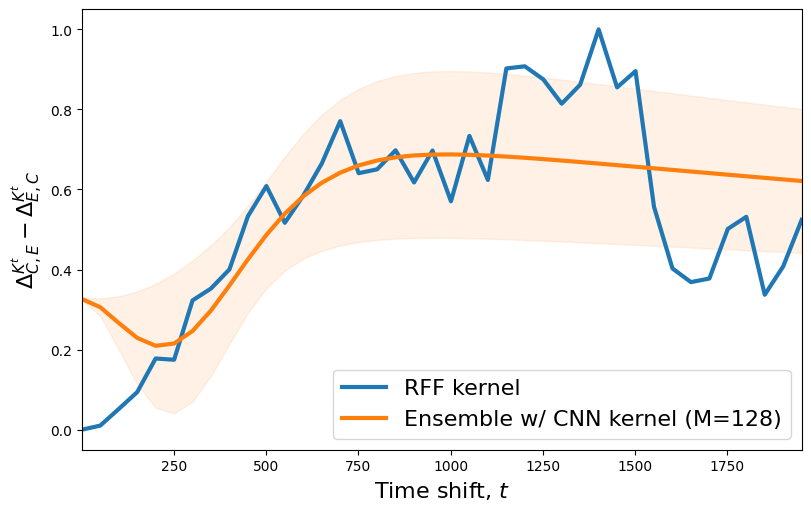

In [14]:
# Uncertainty quantification

## RFF
causal_koopman_rff = Kausal(
    marginal_observable = RandomFourierFeatures(M=500),
    joint_observable = RandomFourierFeatures(M=500),
    cause = omega_2, 
    effect = omega_1
)
noncausal_koopman_rff = Kausal(
    marginal_observable = RandomFourierFeatures(M=500),
    joint_observable = RandomFourierFeatures(M=500),
    cause = omega_1, 
    effect = omega_2
)

causal_effect_rff = causal_koopman_rff.evaluate_multistep(time_shifts = time_shifts)
non_causal_effect_rff = noncausal_koopman_rff.evaluate_multistep(time_shifts = time_shifts)

## CNN
n_members = 5

causal_effect_cnn = []
non_causal_effect_cnn = []

for _ in range(n_members):

    causal_koopman_cnn = Kausal(
        marginal_observable = CNNFeatures(in_channels=1, hidden_channels=hidden_channels, out_channels=1),
        joint_observable = CNNFeatures(in_channels=2, hidden_channels=hidden_channels, out_channels=1),
        cause = omega_2,
        effect = omega_1
    )
    
    
    noncausal_koopman_cnn = Kausal(
        marginal_observable = CNNFeatures(in_channels=1, hidden_channels=hidden_channels, out_channels=1),
        joint_observable = CNNFeatures(in_channels=2, hidden_channels=hidden_channels, out_channels=1),
        cause = omega_1,
        effect = omega_2
    )

    _, _ = causal_koopman_cnn.fit(
        n_train = n_train, 
        epochs = epochs, 
        lr = lr, 
        batch_size = batch_size
    )
    
    _, _ = noncausal_koopman_cnn.fit(
        n_train = n_train, 
        epochs = epochs, 
        lr = lr, 
        batch_size = batch_size
    )

    with torch.no_grad():
        causal_effect_cnn.append(causal_koopman_cnn.evaluate_multistep(time_shifts = time_shifts))
        non_causal_effect_cnn.append(noncausal_koopman_cnn.evaluate_multistep(time_shifts = time_shifts))

causal_effect_cnn = torch.stack(causal_effect_cnn)
non_causal_effect_cnn = torch.stack(non_causal_effect_cnn)

# Plot causal shift
# NOTE: increasing causal error in the true causal direction as time dependency increases.
# NOTE: also significant difference between C --> E and E --> C, indicating strong causal signal between C --> E.
# NOTE: due to the low value of states, we rescale causal measures to be [-1,1]
# NOTE: the negative measure indicates insignificant causal signal

f, ax = plt.subplots(1, 1, figsize=(8, 5), constrained_layout=True)
plt.rcParams.update({
    "font.size": 14,                # General font size
    "axes.titlesize": 16,           # Title font size
    "axes.labelsize": 16,           # Axis label font size
    "xtick.labelsize": 12,          # X-axis tick label size
    "ytick.labelsize": 12,          # Y-axis tick label size
    "legend.fontsize": 16,          # Legend font size
    "lines.linewidth": 3,           # Line width
    "figure.dpi": 300,              # Higher DPI for clearer output
})

diff_rff = normalize(causal_effect_rff - non_causal_effect_rff)
diff_cnn = normalize(causal_effect_cnn - non_causal_effect_cnn)

# Plot the causal and non-causal effects
ax.plot(time_shifts, diff_rff, linestyle='-', color='C0', label='RFF kernel')
ax.plot(time_shifts, diff_cnn.mean(axis=0), linestyle='-', label=r'Ensemble w/ CNN kernel (M=128)', color='C1')
ax.fill_between(
    time_shifts,
    diff_cnn.mean(axis=0) - diff_cnn.std(axis=0),
    diff_cnn.mean(axis=0) + diff_cnn.std(axis=0),
    color='C1',
    alpha=0.1
)

ax.set_xlabel(r'Time shift, $t$', fontsize=16)
ax.set_xlim([time_shifts[0], time_shifts[-1]])
ax.set_ylabel(r'$\Delta^{K^t}_{C,E} - \Delta^{K^t}_{E,C}$', fontsize=16)
    
plt.legend()
plt.show()
# f.savefig("docs/reaction_diffusion_estimation.png", dpi=300, bbox_inches="tight");


# 5. More Experiments

### 5.1 Causal direction

In [15]:
from tabulate import tabulate

# Prepare data & test settings
cause, effect = omega_2, omega_1
time_shift, n_permutes = 1000, 30

# Run VARLiNGAM & PCMCI+
results = {
    "VARLiNGAM":  conditional_varlingam(cause.mean(axis=(1,2)), effect.mean(axis=(1,2))),
    "PCMCI+":     conditional_tigramite(cause.mean(axis=(1,2)), effect.mean(axis=(1,2))),
}

# Helper to run Kausal forward/reverse
def kausal_pvals(obs_kwargs, fit_kwargs=None):
    fwd = Kausal(cause=cause, effect=effect, **obs_kwargs)
    rev = Kausal(cause=effect, effect=cause, **obs_kwargs)
    if fit_kwargs:
        _, _ = fwd.fit(**fit_kwargs)
        _, _ = rev.fit(**fit_kwargs)
        
    p_true  = stats.hypothesis_testing(estimator=fwd, time_shift=time_shift, n_permutes=n_permutes)
    p_false = stats.hypothesis_testing(estimator=rev, time_shift=time_shift, n_permutes=n_permutes)
    return p_true, p_false

# Kausal (RFF)
rff_kwargs = {
    "marginal_observable": RandomFourierFeatures(M=500),
    "joint_observable":    RandomFourierFeatures(M=500),
}
results["Kausal (RFF)"] = kausal_pvals(rff_kwargs)

# Kausal (CNN)
cnn_kwargs = {
    "marginal_observable": CNNFeatures(in_channels=1, hidden_channels=hidden_channels, out_channels=1),
    "joint_observable":    CNNFeatures(in_channels=2, hidden_channels=hidden_channels, out_channels=1),
}
results["Kausal (CNN)"] = kausal_pvals(
    cnn_kwargs, 
    fit_kwargs={"n_train": n_train, "epochs": epochs, "lr": lr, "batch_size": batch_size})

# Tabulate
true_rows  = [[m, "True",  pt] for m, (pt, _) in results.items()]
false_rows = [[m, "False", pf] for m, (_, pf) in results.items()]

print(tabulate(true_rows,  headers=["Method","Direction","p-value (↓ is better)"], tablefmt="fancy_grid"))
print(tabulate(false_rows, headers=["Method","Direction","p-value (↑ is better)"], tablefmt="fancy_grid"))


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:22<00:00,  2.19it/s]


╒══════════════╤═════════════╤═════════════════════════╕
│ Method       │ Direction   │   p-value (↓ is better) │
╞══════════════╪═════════════╪═════════════════════════╡
│ VARLiNGAM    │ True        │               0         │
├──────────────┼─────────────┼─────────────────────────┤
│ PCMCI+       │ True        │               0.740873  │
├──────────────┼─────────────┼─────────────────────────┤
│ Kausal (RFF) │ True        │               0.0322581 │
├──────────────┼─────────────┼─────────────────────────┤
│ Kausal (CNN) │ True        │               0.0322581 │
╘══════════════╧═════════════╧═════════════════════════╛
╒══════════════╤═════════════╤═════════════════════════╕
│ Method       │ Direction   │   p-value (↑ is better) │
╞══════════════╪═════════════╪═════════════════════════╡
│ VARLiNGAM    │ False       │             0           │
├──────────────┼─────────────┼─────────────────────────┤
│ PCMCI+       │ False       │             1.95072e-13 │
├──────────────┼─────────────┼─

### 5.2 Causal magnitudes

In [16]:
# Parameters
n_skip         = 50
window_length  = 10
tau_max        = 1

# Prepare data
cause       = omega_2[..., ::n_skip]   # v
effect      = omega_1[..., ::n_skip]   # u
time_shifts = torch.arange(1, effect.shape[-1])
time_idx    = torch.arange(len(time_shifts))

# Helper to run Kausal with optional fitting
def kausal_magnitude(obs_kwargs, n_members=1, fit_kwargs=None, deterministic=True):
    """
    Instantiate & optionally fit n_members Kausal models, then evaluate.
    If deterministic=True, reseed torch & numpy per member for reproducibility.
    """
    results = []
    for m in range(n_members):
        if deterministic:
            torch.manual_seed(m)
            np.random.seed(m)
            torch.use_deterministic_algorithms(True)

        model = Kausal(cause=cause, effect=effect, **obs_kwargs)
        if fit_kwargs:
            model.fit(**fit_kwargs)
        with torch.no_grad():
            results.append(
                model.evaluate_multistep(time_shifts=time_shifts, init_idx=0)
            )

    return normalize(torch.stack(results))


# — RFF
rff_kwargs = {
    "marginal_observable": RandomFourierFeatures(M=500),
    "joint_observable":    RandomFourierFeatures(M=500),
}
causal_effect_rff = kausal_magnitude(rff_kwargs)


# — TDF
tdf_kwargs = {
    "marginal_observable": TimeDelayFeatures(n_delays=6),
    "joint_observable":    TimeDelayFeatures(n_delays=6),
}
causal_effect_tdf = kausal_magnitude(tdf_kwargs)


# — CNN
hidden_channels = [16, 32, 64, 128]
cnn_kwargs = {
    "marginal_observable": CNNFeatures(in_channels=1, hidden_channels=hidden_channels, out_channels=1),
    "joint_observable":    CNNFeatures(in_channels=2, hidden_channels=hidden_channels, out_channels=1),
}
fit_kwargs = {
    "n_train":    effect.shape[-1],
    "epochs":     epochs,
    "lr":         lr,
    "batch_size": effect.shape[-1]//n_skip,
}
causal_effect_cnn = kausal_magnitude(
    cnn_kwargs,
    n_members=5,
    fit_kwargs=fit_kwargs
)


# — PCMCI+
causal_effect_pcmciplus = magnitude_tigramite(
    cause= cause.mean(dim=(1,2)),
    effect=effect.mean(dim=(1,2)),
    window_length=window_length,
    tau_max=tau_max
)


# — VARLiNGAM
causal_effect_varlingam = magnitude_varlingam(
    cause= cause.mean(dim=(1,2)),
    effect=effect.mean(dim=(1,2)),
    window_length=window_length,
    tau_max=tau_max
)


# — TSCI
causal_effect_tsci = magnitude_tsci(
    cause= cause.mean(dim=(1,2)),
    effect=effect.mean(dim=(1,2)),
    window_length=window_length,
    tau_max=tau_max
)

# — cLSTM
causal_effect_clstm = magnitude_clstm(
    cause= cause.mean(dim=(1,2)),
    effect=effect.mean(dim=(1,2)),
    window_length=window_length,
    tau_max=tau_max
)


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [01:28<00:00,  2.26it/s]


Plotting different overlays for causal magnitude analysis!

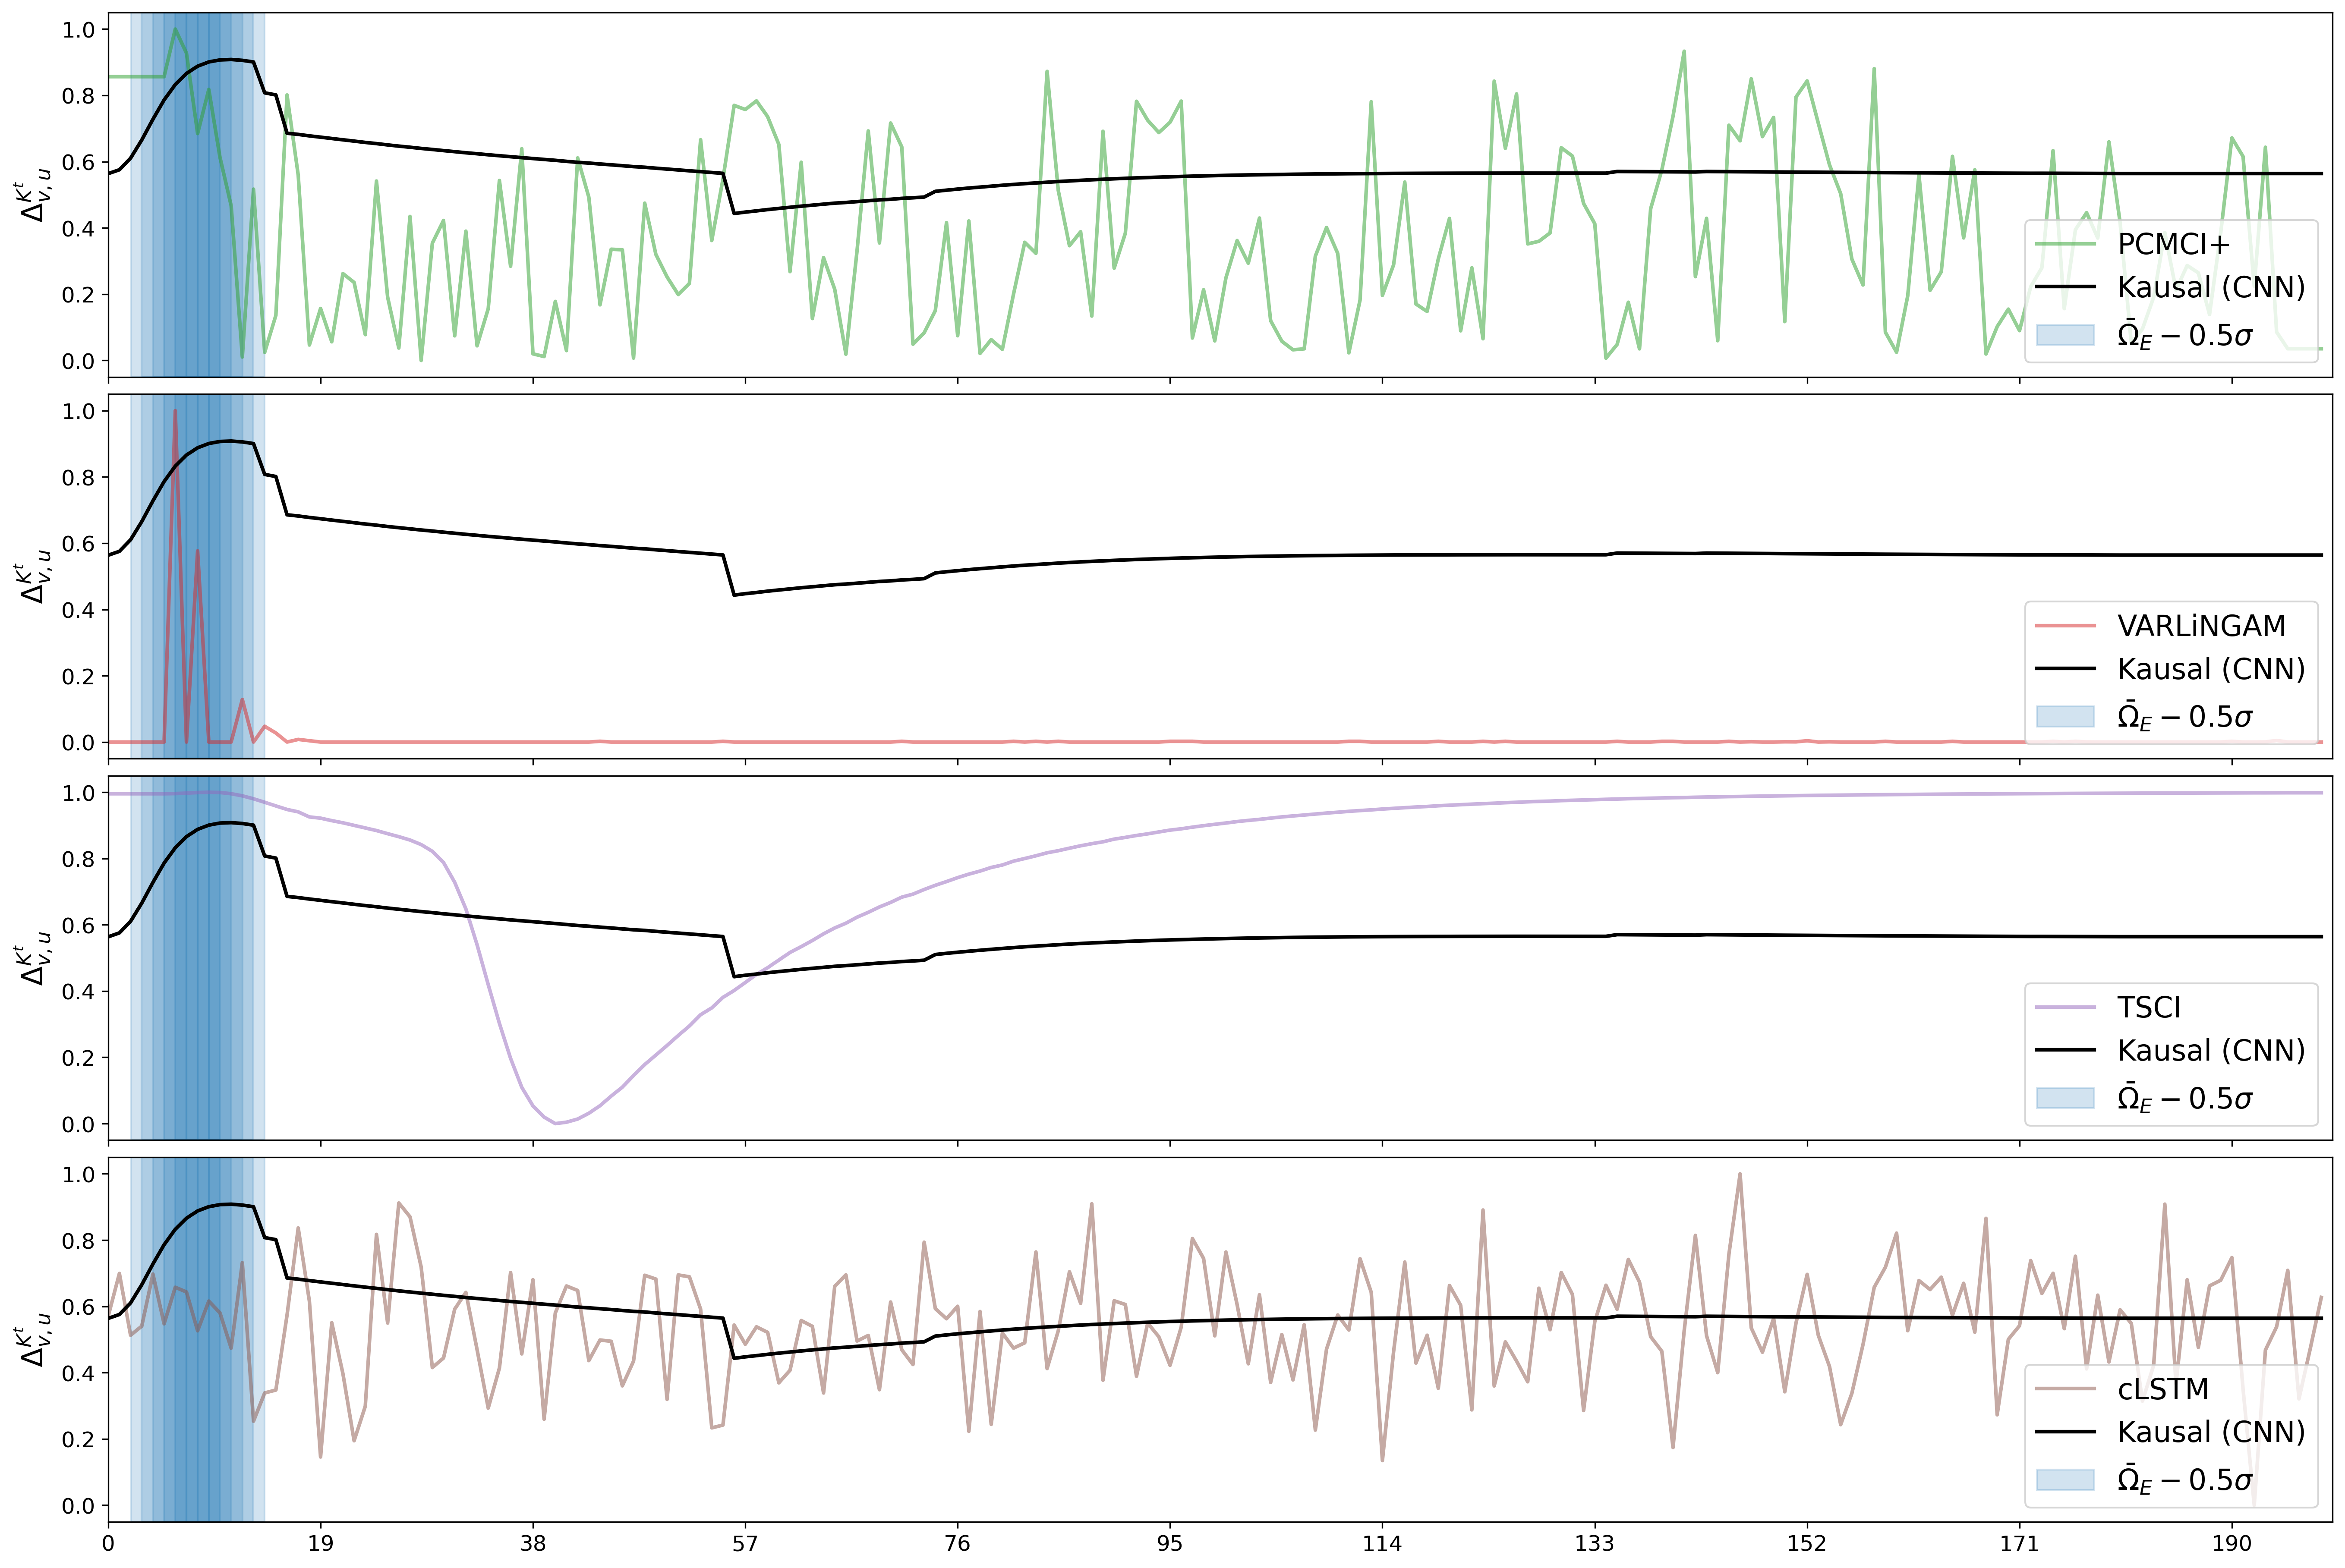

In [17]:
# Overlay baselines
baselines = [
    ("PCMCI+", causal_effect_pcmciplus, 'C2'),
    ("VARLiNGAM", causal_effect_varlingam, 'C3'),
    ("TSCI", causal_effect_tsci, 'C4'),
    ("cLSTM", causal_effect_clstm, 'C5')
]

fig, axes = plt.subplots(len(baselines), 1, figsize=(18, 3*len(baselines)), sharex=True, sharey=True, constrained_layout=True)
axes = axes.flatten()

# For each baseline, plot the baseline and Kausal on the same subplot.
for ax, (label, baseline, color) in zip(axes, baselines):
    # Plot the baseline causal effect
    ax.plot(baseline, color=color, linestyle='solid', alpha=0.5, label=label, linewidth=2)
    kausal_mean = causal_effect_cnn.mean(axis=0)
    ax.plot(kausal_mean, color='black', linestyle='solid', alpha=1.0, label='Kausal (CNN)', linewidth=2)
    
    ax.set_ylabel(r'$\Delta^{K^t}_{v,u}$', size=16)
    ax.set_xlim([time_shifts[0], time_shifts[-1]])
    ax.set_xticks(range(0, len(time_shifts), len(time_shifts) // 10))
    
    # Overlay anomalies in background
    plot_anomalies(ax=ax, X=effect.mean(axis=(1,2)), time_idx=time_idx, thres=0.5)
    ax.legend(loc='lower right')

plt.show()
# fig.savefig("docs/reaction_diffusion_baselines_estimation.png", dpi=300, bbox_inches="tight");


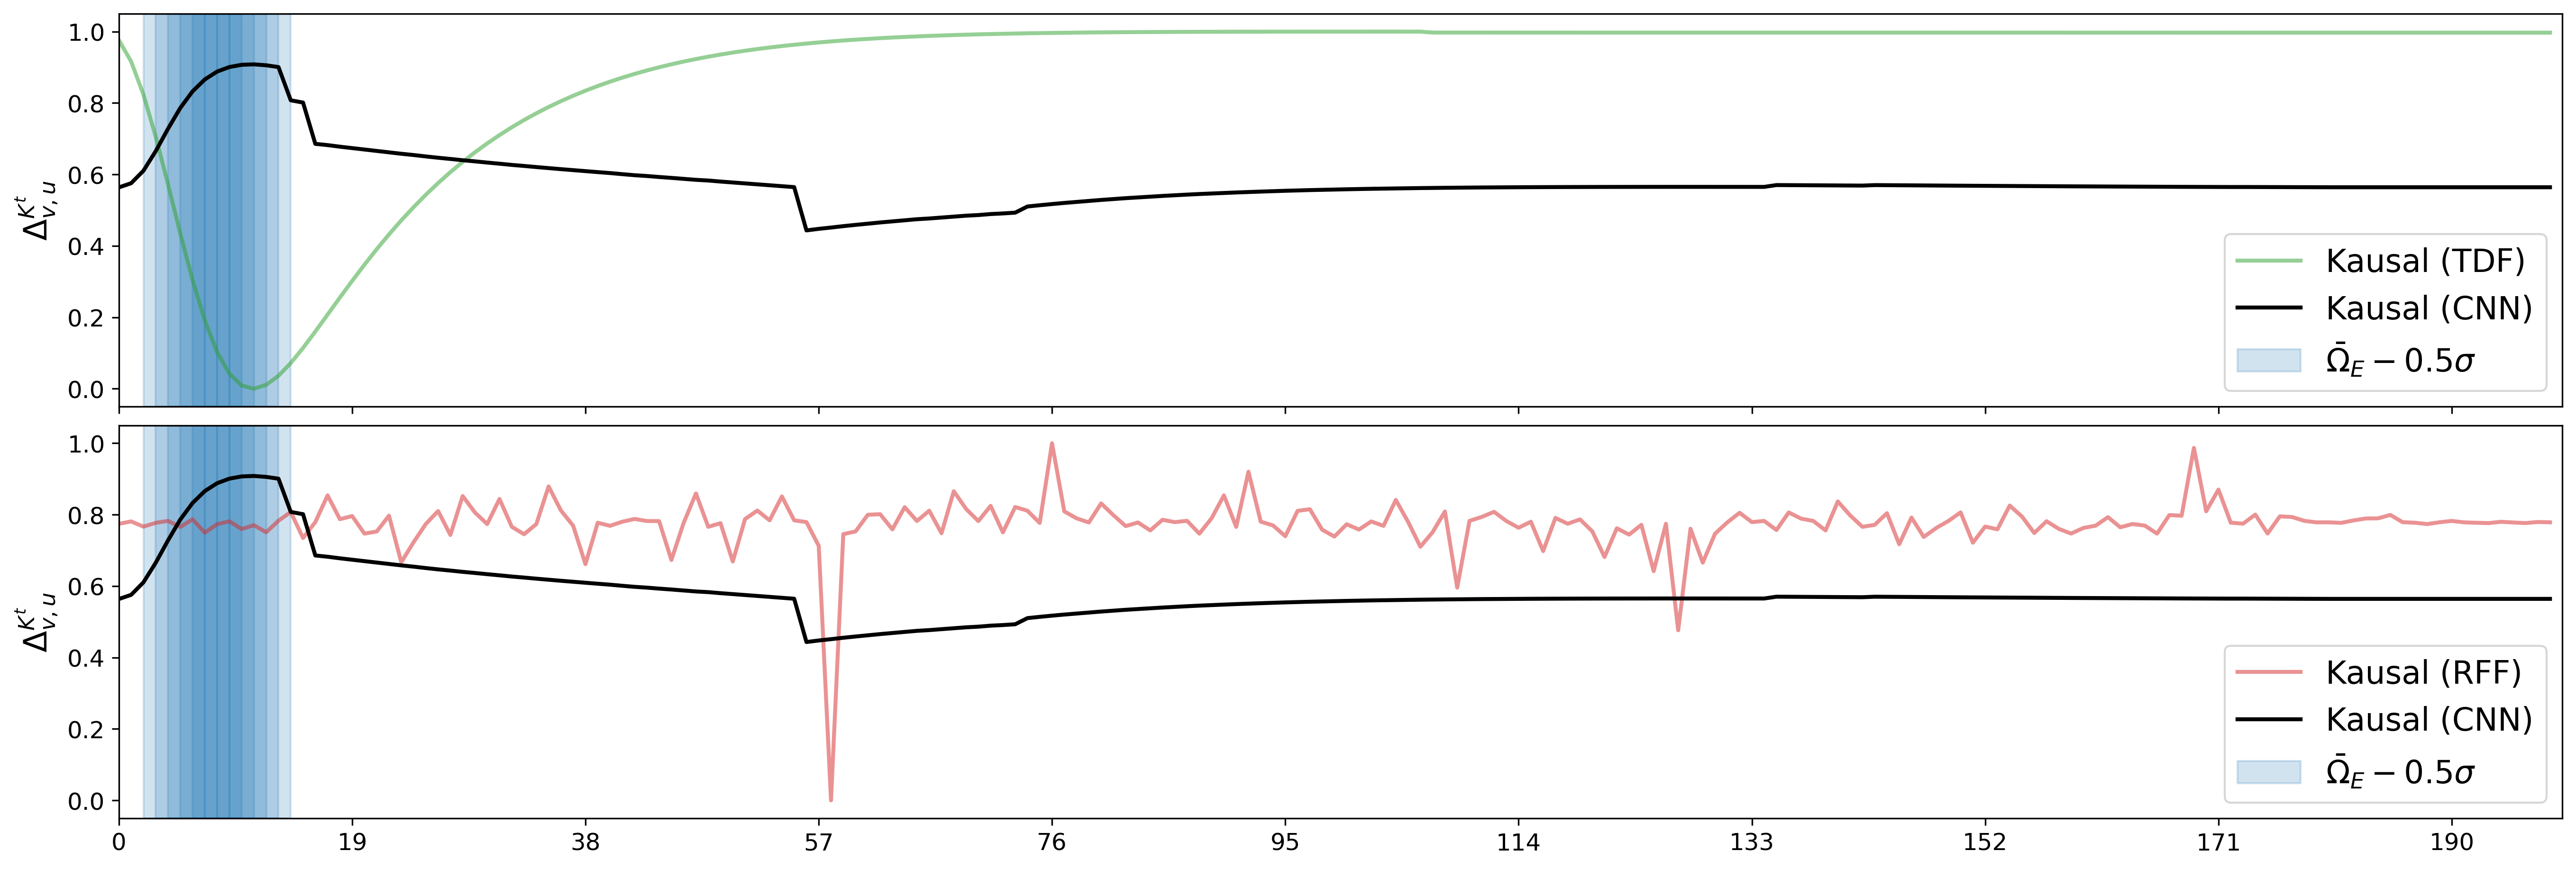

In [18]:
# Overlay Kausal variants
baselines = [
    ("Kausal (TDF)", causal_effect_tdf.mean(axis=0), 'C2'),
    ("Kausal (RFF)", causal_effect_rff.mean(axis=0), 'C3'),
]

fig, axes = plt.subplots(2, 1, figsize=(18, 6), sharex=True, sharey=True, constrained_layout=True)
axes = axes.flatten()

# For each baseline, plot the baseline and Kausal on the same subplot.
for ax, (label, baseline, color) in zip(axes, baselines):
    # Plot the baseline causal effect
    ax.plot(baseline, color=color, linestyle='solid', alpha=0.5, label=label, linewidth=2)
    kausal_mean = causal_effect_cnn.mean(axis=0)
    ax.plot(kausal_mean, color='black', linestyle='solid', alpha=1.0, label='Kausal (CNN)', linewidth=2)
    
    ax.set_ylabel(r'$\Delta^{K^t}_{v,u}$', size=16)
    ax.set_xlim([time_shifts[0], time_shifts[-1]])
    ax.set_xticks(range(0, len(time_shifts), len(time_shifts) // 10))
    
    # Overlay ENSO anomalies in background
    plot_anomalies(ax=ax, X=effect.mean(axis=(1,2)), time_idx=time_idx, thres=0.5)
    ax.legend(loc='lower right')

plt.show()
# fig.savefig("docs/reaction_diffusion_kausal_estimation.png", dpi=300, bbox_inches="tight");


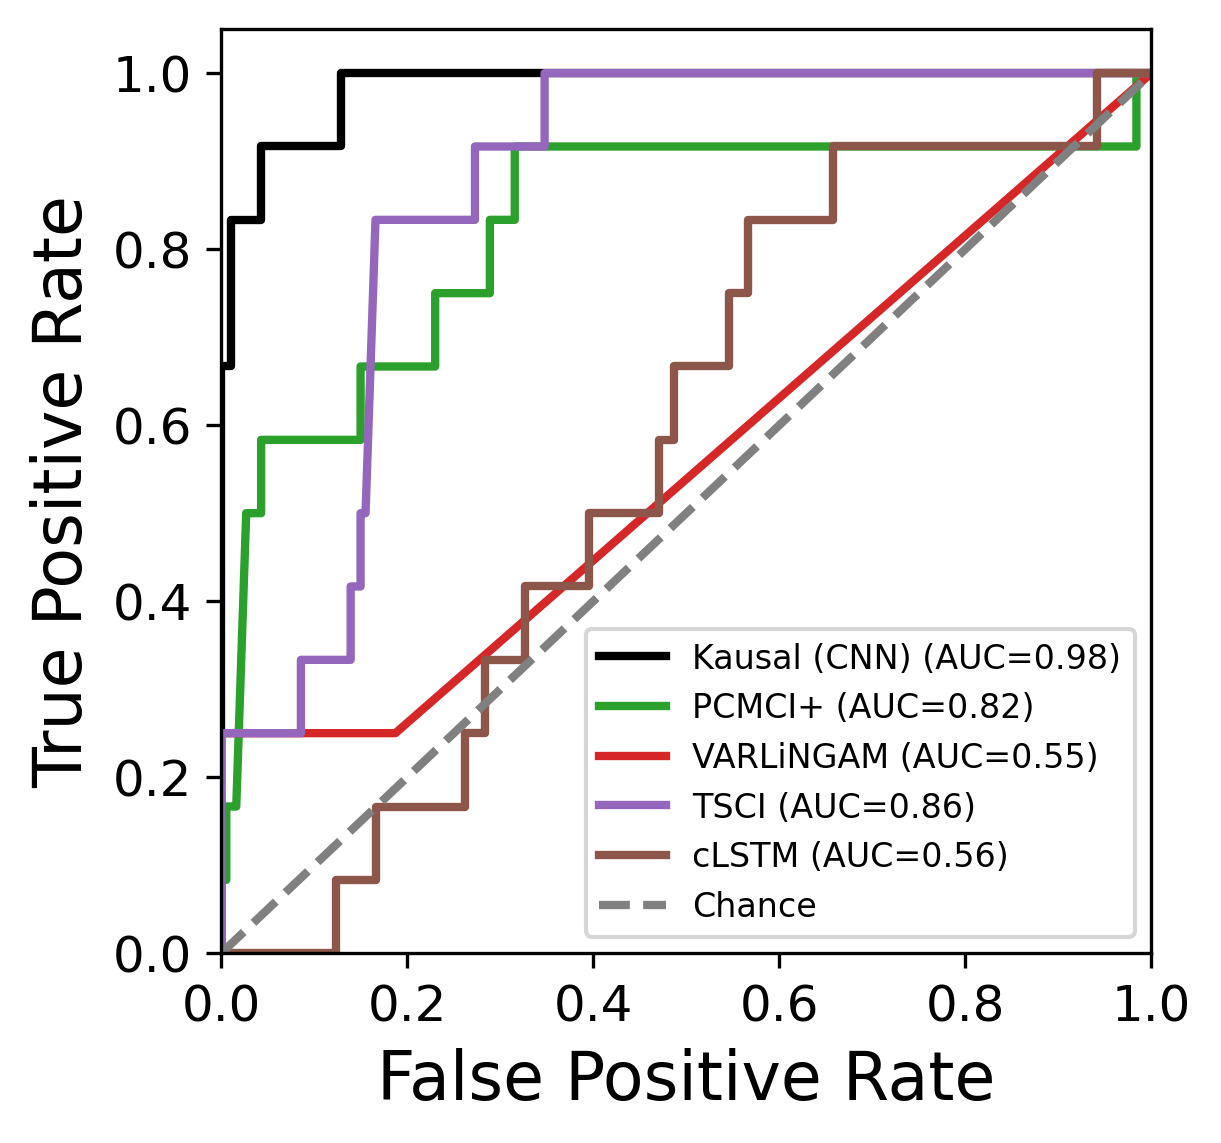

<Figure size 1920x1440 with 0 Axes>

In [19]:
# AUROC baselines
anom_events = get_anomalies(effect.mean(axis=(1,2)), time_idx, thres=0.5)
y_true = anom_events.astype(int)
y_scores = [causal_effect_cnn.mean(axis=0), causal_effect_pcmciplus, causal_effect_varlingam, causal_effect_tsci, causal_effect_clstm]
labels = ['Chance', 'Kausal (CNN)', 'PCMCI+', 'VARLiNGAM', 'TSCI', 'cLSTM']
colors = ['lightgrey', 'black', 'C2', 'C3', 'C4', 'C5']

plt.figure(figsize=(4,4))
for i, y_score in enumerate(y_scores, 1):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, color=colors[i], label=f'{labels[i]} (AUC={roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right", fontsize=8)
plt.show()
# plt.savefig("docs/reaction_diffusion_baselines_auroc.png", dpi=300, bbox_inches="tight");


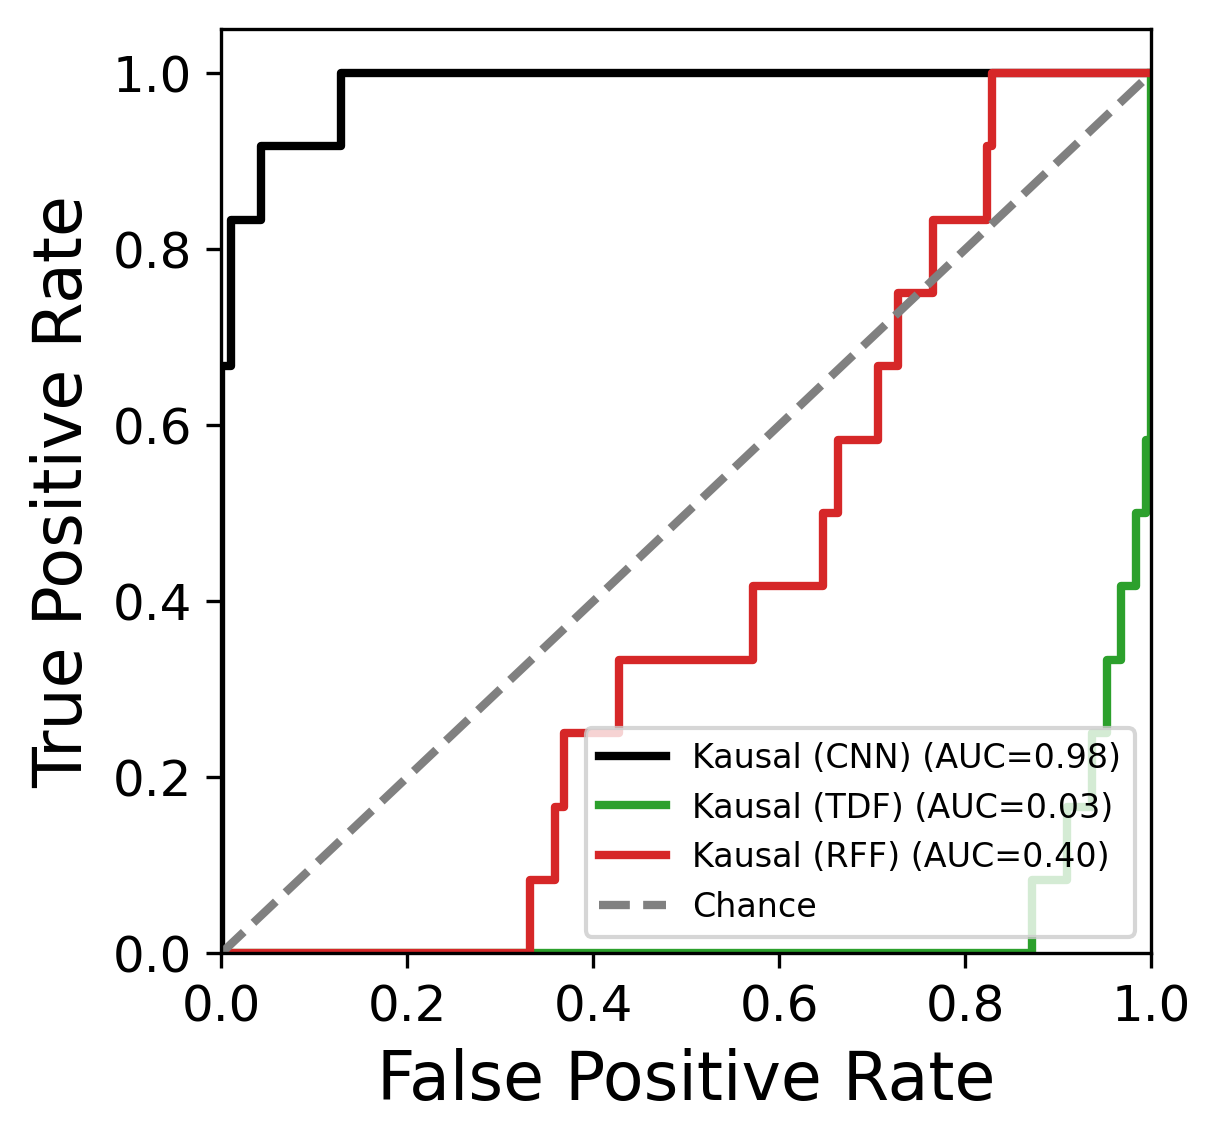

<Figure size 1920x1440 with 0 Axes>

In [20]:
# AUROC Kausal variants
anom_events = get_anomalies(effect.mean(axis=(1,2)), time_idx, thres=0.5)
y_true = anom_events.astype(int)
y_scores = [causal_effect_cnn.mean(axis=0), causal_effect_tdf.mean(axis=0), causal_effect_rff.mean(axis=0)]
labels = ['Chance', 'Kausal (CNN)', 'Kausal (TDF)', 'Kausal (RFF)']
colors = ['lightgrey', 'black', 'C2', 'C3']

plt.figure(figsize=(4,4))
for i, y_score in enumerate(y_scores, 1):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, color=colors[i], label=f'{labels[i]} (AUC={roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right", fontsize=8)
plt.show()
# plt.savefig("docs/reaction_diffusion_kausal_auroc.png", dpi=300, bbox_inches="tight");
